In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import pickle

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import Input

from keras.metrics import mean_squared_error
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/ai_project/data/f10-7.pkl', 'rb') as f:
    df = pickle.load(f)

n = 30 # 30일간 데이터 input
test_num = 10 # 10일간 데이터 output

df_forplot = df[-test_num:]
df = df[:-test_num]

# 이후 10일 데이터 예측
X = np.array([df['value'].values[i:i+n] for i in range(len(df)-n-test_num+1)])
y = np.array([df['value'].values[i+n:i+n+test_num] for i in range(len(df)-n-test_num+1)])

# plt.plot(df['value'].values[:100])
# plt.plot(X[0], color='orange')
# plt.plot(range(30, 30+test_num), y[0], color='green')
# plt.xticks([10*i for i in range(11)])
# plt.grid(True)

X = X.reshape((-1, 30, 1))
y = y.reshape((-1, 10, 1))

def plot_result(his):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(his.history['loss'])
    ax1.plot(his.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')

    ax2.plot(his.history['mae'])
    ax2.plot(his.history['val_mae'])
    ax2.set_title('Model MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=42)

mse = tf.keras.losses.MeanSquaredError()

Mounted at /content/drive


# Model

In [ ]:
hidden_size = 200

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense

# Encoder
encoder_inputs = Input(shape=(30, 1))  # 30 time steps
encoder = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = RepeatVector(10)(encoder_outputs)  # 10 time steps
decoder_lstm = LSTM(hidden_size, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

model2 = Model(encoder_inputs, decoder_outputs)

model2.compile(loss='mse', optimizer='adam', metrics=['mae'])

model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 lstm_10 (LSTM)              [(None, 200),                161600    ['input_7[0][0]']             
                              (None, 200),                                                        
                              (None, 200)]                                                        
                                                                                                  
 repeat_vector_4 (RepeatVec  (None, 10, 200)              0         ['lstm_10[0][0]']             
 tor)                                                                                       

In [ ]:
history2 = model2.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/30
519/519 [==============================] - 51s 11ms/step - loss: 7535.9214 - mae: 66.5378 - val_loss: 3445.1367 - val_mae: 39.8009
Epoch 2/30
519/519 [==============================] - 6s 13ms/step - loss: 2143.3396 - mae: 28.2214 - val_loss: 1274.5826 - val_mae: 20.7881
Epoch 3/30
519/519 [==============================] - 4s 8ms/step - loss: 971.8366 - mae: 18.3063 - val_loss: 716.6770 - val_mae: 16.1216
Epoch 4/30
519/519 [==============================] - 4s 8ms/step - loss: 621.2080 - mae: 14.9919 - val_loss: 534.2324 - val_mae: 14.7904
Epoch 5/30
519/519 [==============================] - 6s 11ms/step - loss: 513.5153 - mae: 13.8656 - val_loss: 448.4911 - val_mae: 12.7961
Epoch 6/30
519/519 [==============================] - 5s 9ms/step - loss: 445.6947 - mae: 13.0702 - val_loss: 413.5947 - val_mae: 12.5750
Epoch 7/30
519/519 [==============================] - 4s 8ms/step - loss: 411.9180 - mae: 12.7547 - val_loss: 381.1455 - val_mae: 12.3982
Epoch 8/30
519/519 [======

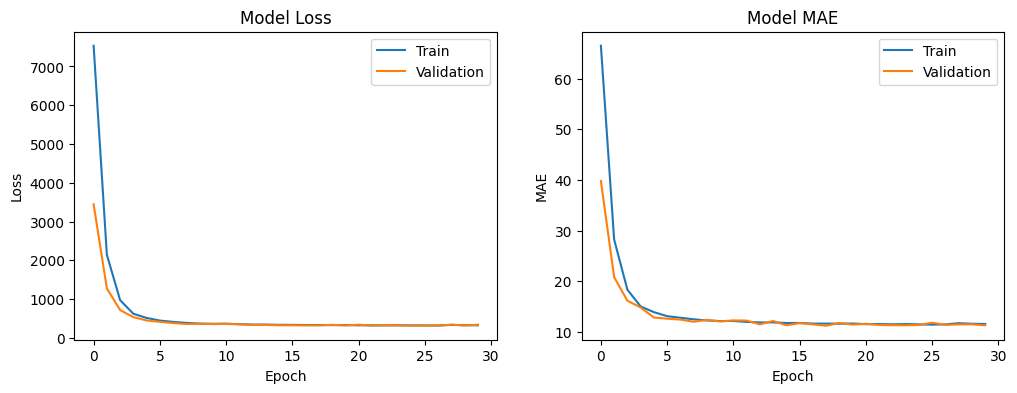

In [ ]:
plot_result(history2)

In [ ]:
pred_model2 = model2.predict(X_test)

163/163 [==============================] - 1s 4ms/step


In [ ]:
error = mse(y_test, pred_model2).numpy()
print("Mean Squared Error on Test Data:", error)

Mean Squared Error on Test Data: 319.55026


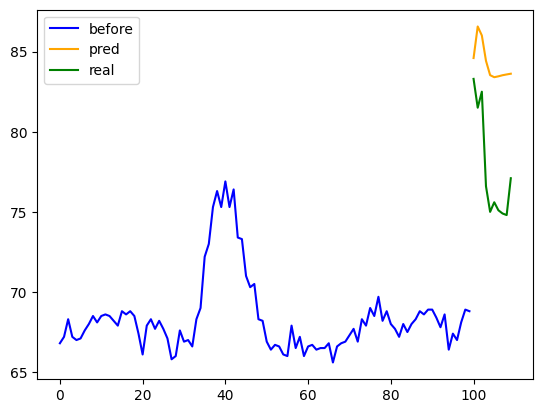

In [ ]:
left_num = 100
test_num = 10

i = 14

plt.plot(df['value'].values[-left_num-test_num:-test_num], label='before', color='blue')
plt.plot(range(left_num, left_num+test_num), pred_model2[i], label='pred', color='orange')
plt.plot(range(left_num, left_num+test_num), y_test[i], label='real', color='green')
plt.legend()

In [ ]:
# model2.save('/content/drive/My Drive/ai_project/model/seq2seq_2_fs.keras')